In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read 
file = pd.ExcelFile("..\data\\food-twentieth-century-crop-statistics-1900-2017-xlsx.xlsx")
df = file.parse('CropStats')
df = df.set_index(df.columns[0])
df.index.name = None


The way I understand it the sheet 'CropStats' contains all data from the other sheets, so I am only using that one.


In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36707 entries, 0 to 36706
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Harvest_year         36707 non-null  int64  
 1   admin0               36707 non-null  object 
 2   admin1               33716 non-null  object 
 3   crop                 36707 non-null  object 
 4   hectares (ha)        35084 non-null  float64
 5   production (tonnes)  34709 non-null  float64
 6   year                 36707 non-null  int64  
 7   yield(tonnes/ha)     34694 non-null  float64
 8   admin2               0 non-null      float64
 9   notes                5641 non-null   object 
dtypes: float64(4), int64(2), object(4)
memory usage: 3.1+ MB


In [198]:
df.head()

,national,subnational,crop,hectares (ha),production (tonnes),year,yield(tonnes/ha),log_hectares,log_production,log_yield
59,Austria,Austria,wheat,275822.0,711620.760,1961,2.580,12.527515,13.475302,1.275363
60,Austria,Austria,wheat,270351.0,706156.812,1962,2.612,12.507480,13.467594,1.284262
61,Austria,Austria,wheat,274722.0,689552.220,1963,2.510,12.523519,13.443799,1.255616
62,Austria,Austria,wheat,282967.0,750428.484,1964,2.652,12.553089,13.528401,1.295275
63,Austria,Austria,wheat,275654.0,660742.638,1965,2.397,12.526905,13.401121,1.222893


In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34155 entries, 59 to 36706
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   national             34155 non-null  object 
 1   subnational          34155 non-null  object 
 2   crop                 34155 non-null  object 
 3   hectares (ha)        34155 non-null  float64
 4   production (tonnes)  34155 non-null  float64
 5   year                 34155 non-null  int64  
 6   yield(tonnes/ha)     34155 non-null  float64
 7   log_hectares         34155 non-null  float64
 8   log_production       34155 non-null  float64
 9   log_yield            34155 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.9+ MB


based on the amount off null values I am starting by omitting admin2 (0 non-null) and notes (5641), also don't think those would have been meaningful regardless.

In [168]:
df.drop(['admin2', 'notes', 'Harvest_year'], axis=1, inplace=True)

admin0 indicates the national levels (countries).  
admin1 indicates the subnational levels (states).  
this is confusing for me so i am changing the column names.

In [169]:
df.rename(columns = {'admin0': 'national', 'admin1': 'subnational'}, inplace=True)

In [196]:
df.loc[df['subnational'].isna(), 'subnational'] = df['national']

hectares, production and yield have some null values  
<del>I have decided to remove all rows with null values in these columns as i think these are the most important columns  
this leaves us with 33477 rows (still 91.20% of the original 36707) which i believe to still be plenty  
I think simply omitting these is a better idea than replacing them with averages for these two reasons</del>  

if yield is nan, but hectares and production are not, we can calculate yield. This occurs 1115 times. Other rows with NaN for yield are dropped. we also cannot calculate the yield when hectares is 0, this would give inf yield.

In [170]:
len(df[(pd.isnull(df['yield(tonnes/ha)'])) & (~pd.isnull(df['production (tonnes)'])) & ~pd.isnull(df['hectares (ha)'])])


1115

In [171]:
mask = df['yield(tonnes/ha)'].isna() & ~df['production (tonnes)'].isna() & ~df['hectares (ha)'].isna() & df['hectares (ha)'] != 0
df.loc[mask, 'yield(tonnes/ha)'] = df['production (tonnes)'] / df['hectares (ha)']
df.dropna(subset=['yield(tonnes/ha)'], inplace=True)


if production is nan, but hectares and yield are not, we can calculate production. This occurs 483 times. Other rows where production is NaN are dropped.

In [172]:
len(df[~pd.isnull(df['hectares (ha)']) & pd.isnull(df['production (tonnes)']) & ~pd.isnull(df['yield(tonnes/ha)'])])


483

In [173]:
# The mask is used here because of I did the same way as above it kept timing out
mask = df['production (tonnes)'].isna() & ~df['yield(tonnes/ha)'].isna() & ~df['hectares (ha)'].isna()
df.loc[mask, 'production (tonnes)'] = df['yield(tonnes/ha)'] * df['hectares (ha)']
df.dropna(subset=['production (tonnes)'], inplace=True)


if hectares is NaN, and production and yield are not, hectares can be calculated, this occurs 106 times. Other rows where hectares is NaN are dropped.

In [174]:
mask = df['hectares (ha)'].isna() & ~df['yield(tonnes/ha)'].isna() & ~df['production (tonnes)'].isna()
df.loc[mask, 'hectares (ha)'] = df['yield(tonnes/ha)'] * df['production (tonnes)']
df.dropna(subset=['hectares (ha)'], inplace=True)

In [175]:
# The columns we just adapted just changed into objects, let's make them floats again
df['hectares (ha)'] = df['hectares (ha)'].astype(float)
df['production (tonnes)'] = df['production (tonnes)'].astype(float)
df['yield(tonnes/ha)'] = df['yield(tonnes/ha)'].astype(float)

In [176]:
# Assuming df is your DataFrame
zero_hectares_rows = df[df['hectares (ha)'] == 0]

# Print or display the rows where 'hectares (ha)' is 0
print(zero_hectares_rows)

Empty DataFrame
Columns: [national, subnational, crop, hectares (ha), production (tonnes), year, yield(tonnes/ha)]
Index: []


In [192]:
df.describe()

,hectares (ha),production (tonnes),year,yield(tonnes/ha),log_hectares,log_production,log_yield
count,3.415500e+04,3.415500e+04,34155.000000,34155.000000,34155.000000,34155.000000,34155.000000
mean,6.745161e+05,1.634547e+06,1956.119836,2.679773,11.763143,12.417654,1.156719
std,1.616353e+06,5.003067e+06,38.730405,2.239175,2.241392,2.390895,0.517348
min,1.000000e+00,0.000000e+00,1861.000000,0.000000,0.693147,0.000000,0.000000
25%,3.642120e+04,7.022915e+04,1927.000000,1.137703,10.502934,11.159533,0.759732
50%,1.800826e+05,3.302174e+05,1959.000000,1.881500,12.101176,12.707510,1.058311
75%,6.426318e+05,1.243900e+06,1989.000000,3.486162,13.373329,14.033763,1.500997
max,3.147000e+07,1.342875e+08,2019.000000,17.168477,17.264545,18.715494,2.899688


We have a lot of hectares = 0, like a lot, let's see how things change when we drop those

In [178]:
df = df[df['hectares (ha)'] != 0]

In [190]:
df['log_yield'] = np.log1p(df['yield(tonnes/ha)'])


<Axes: xlabel='crop', ylabel='log_yield'>

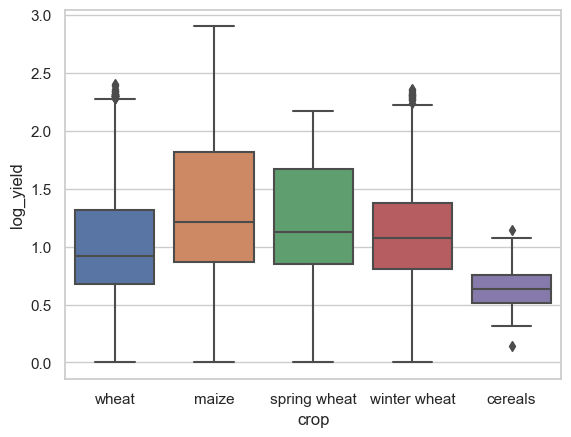

In [191]:
sns.boxplot(data=df, x='crop', y='log_yield')

<Axes: xlabel='crop', ylabel='log_hectares'>

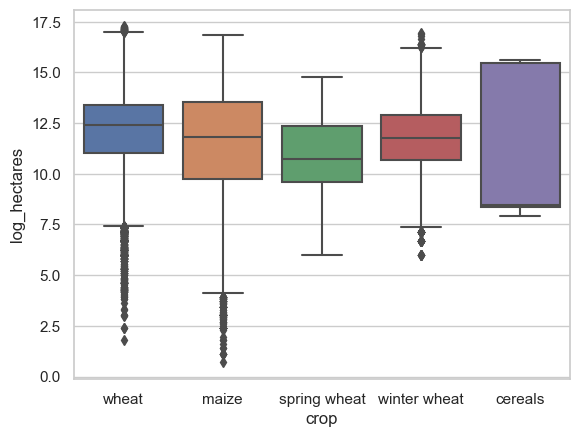

In [184]:
sns.boxplot(data=df, x='crop', y='log_hectares')


In [181]:
df['log_hectares'] = np.log1p(df['hectares (ha)'])

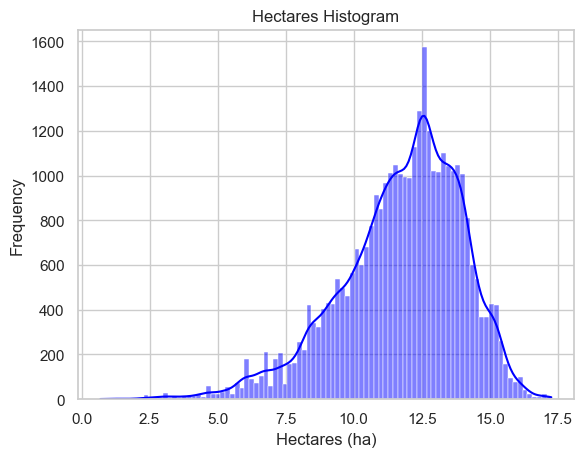

In [183]:
# Assuming df is your DataFrame
sns.set(style="whitegrid")  # Set a seaborn style

# Plot the histogram
sns.histplot(data=df, x='log_hectares', kde=True, color='blue')

# Add labels and title
plt.xlabel('Hectares (ha)')
plt.ylabel('Frequency')
plt.title('Hectares Histogram')

# Show the plot
plt.show()

In [187]:
df['log_production'] = np.log1p(df['production (tonnes)'])


<Axes: xlabel='crop', ylabel='log_production'>

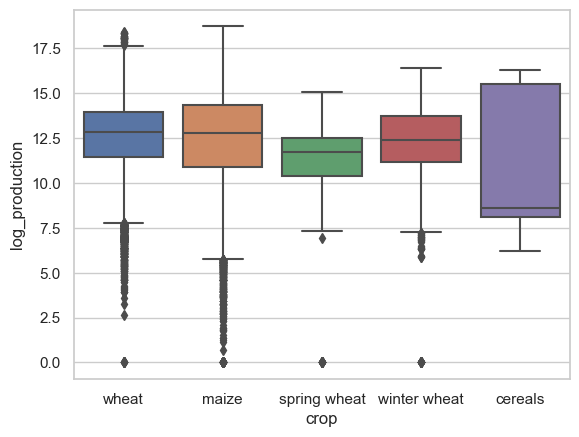

In [189]:
sns.boxplot(data=df, x='crop', y='log_production')


we log transformed the hectares, yield, and production which gives us values that are easier to work with (this type of transformation is a very common thing to do when dealing with a lot of small values/very skewed data)

I think we should work with admin0, admin1, and crop through one hot encoding.  

In [129]:
crop = pd.get_dummies(df['crop'])
crop

# Merge the one-hot encoded columns back into the original DataFrame
df = pd.concat([df, crop], axis=1)

# Drop the original 'age category' column if needed
# df = df.drop(columns=['crop'])

df

,national,subnational,crop,hectares (ha),production (tonnes),year,yield(tonnes/ha),cereals,maize,spring wheat,wheat,winter wheat
59,Austria,NaN,wheat,275822.0,711620.760,1961,2.580000,0,0,0,1,0
60,Austria,NaN,wheat,270351.0,706156.812,1962,2.612000,0,0,0,1,0
61,Austria,NaN,wheat,274722.0,689552.220,1963,2.510000,0,0,0,1,0
62,Austria,NaN,wheat,282967.0,750428.484,1964,2.652000,0,0,0,1,0
63,Austria,NaN,wheat,275654.0,660742.638,1965,2.397000,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
36702,China,zhejiang,wheat,75520.0,278300.000,2013,3.685117,0,0,0,1,0
36703,China,zhejiang,wheat,82120.0,309500.000,2014,3.768875,0,0,0,1,0
36704,China,zhejiang,wheat,89800.0,351300.000,2015,3.912027,0,0,0,1,0
36705,China,zhejiang,wheat,76590.0,253900.000,2016,3.315054,0,0,0,1,0


In [105]:
national = pd.get_dummies(df['national'])
national

,Argentina,Australia,Austria,Belgium,Brazil,Canada,Chile,China,Croatia,Czech Republic,...,Mexico,Morocco,Netherlands,Portugal,South Africa,Spain,Sweden,United Kingdom,United States,Uruguay
59,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36702,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
36703,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
36704,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
36705,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
subnational = pd.get_dummies(df['subnational'])
subnational

,ALABAMA,ARIZONA,ARKANSAS,Aquitaine,Australian Capital Territory,Auvergne,Brittany,Burgundy,CALIFORNIA,COLORADO,...,shaanxi,shandong,shanhai,shanxi,taiwan,valencia,xinjiang,yunnan,zhejiang,Île-de-France
59,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
36703,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
36704,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
36705,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


okay, now i don't know what to do with them, look into count plots

<Axes: >

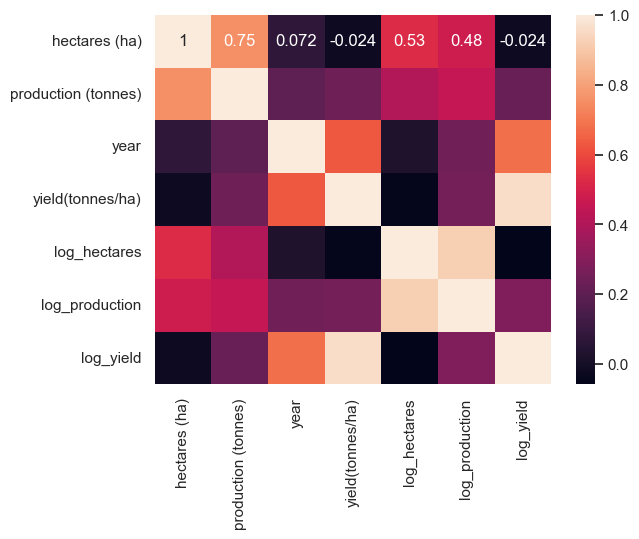

In [199]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True)

In [108]:
corr['production (tonnes)'].sort_values(ascending=False)

production (tonnes)    1.000000
hectares (ha)          0.752794
yield(tonnes/ha)       0.236592
year                   0.200686
Name: production (tonnes), dtype: float64

In [109]:
corr['yield(tonnes/ha)'].sort_values(ascending=False)


yield(tonnes/ha)       1.000000
year                   0.629544
production (tonnes)    0.236592
hectares (ha)         -0.023528
Name: yield(tonnes/ha), dtype: float64

this seems to indicate a relation between production and hectares, production and yield, yield and year (but not production and year)  
production and hectares seem linked (which makes sense), but yield and hectares seem very much not related (which is interesting), neither are yield and production. So it seems that more hectares give more crops, but it has no influence on crops per hectare (which makes a lot of sense actually, nvm).

remove harvest_year (it is the same as year)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


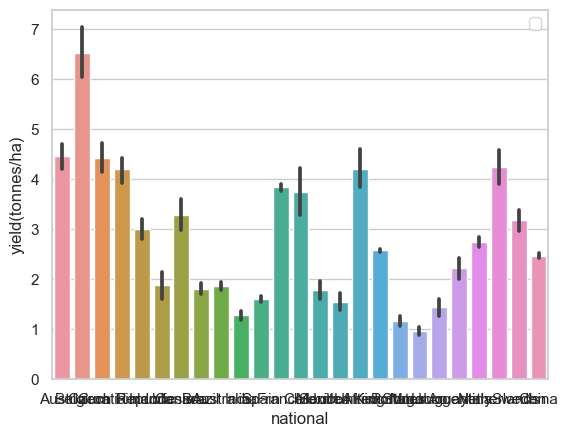

In [209]:
sns.barplot(y=df['yield(tonnes/ha)'], x=df['national'])
plt.legend()
plt.show()